<a href="https://colab.research.google.com/github/PrinceP/MonoRepo/blob/dl_learning/src/colabs/assignments/Submission_Painting_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment link: https://www.notion.so/playment/Playment-ML-Engineer-Assignment-Segmentation-04bbcb8c4b474603829e531aa5fbe852

Create a copy of this Colab file, fill it in, train your model and share along with results

# Overview

This notebook implements the Detectron2 (https://github.com/facebookresearch/detectron2) library on the Bob Ross Paintings dataset to create semantic segmentation masks.

Detectron2 tutorial Colab: https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=h9tECBQCvMv3 

# Dataset overview

Dataset link: https://www.kaggle.com/residentmario/segmented-bob-ross-images

This dataset contains ~250 segmented Bob Ross paintings with 9 classes. Bob Ross was a painter and painting instructor who was on PBS public television for over a decade with his show "The Joy of Painting". Bob Ross is known for his easy-to-learn "wet-on-wet" painting style, the use of vibrant color in his landscape paintings, and for his generally calm, joyous personality.

## Sample images

![picture](https://i.imgur.com/A6T6y6o.png)

![picture](https://www.kaggleusercontent.com/kf/27849031/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..-EbR5fJxZN8giHn9yHKa7A.7kYk5NTpAiuRMj6O6_27rr3fQiczhrWsDJWVeNLtHva63fnEqqT2TzWdxAMn6j12G1K9nFGMBc68J0-f3klcOseFigFP1ZZD7-0i5_gTTuRnSSeADP7eMvxRKvwJuMhV97RONvlxv93gQYfaBsXHE1fGp9Prv02g_hc6t5HaTgUhlQHqK3AMcMiOx61KNK7PQZyNSBgkEUS_8x2ehEYgYvKZaPGVyzAk4DSa3Wh7y6NzQoZUmbxvCfmBhbjsu08DZTYcoSkPMljGuI6db3-XwHrNjhDG77MrlYCUS3KyWok-FQY_T0KNyn-QquXgvlIcBtoMVNnnHI06m2FZMmMDbLKhjrZFtsrCZn9vf7f7huI42zGqKm8Eq6K2jFZbV_tyoiUAW80IDZz0eXCjzvsnCm-9tfpK94O-8wr0rRJFiEL_PNzMFAounoFM49iP7i60aBpr9jedAZtc1h0KIo8Jj3UT-MK3bXWTPVU8rel4jNRkXV9KF01THuyI7Pq7CKepLsCzQytZ70H9RD7np7h2heKwCZwWNN9D9tBwuaUd5_QgZqf3mCnF8SgIGaTbXI-m2a4qQZMygmfOZqBLFsKsb9vECviElPCLUecXPGTjVO6rlkdnt-SlEcx_KJij-SUt4Y4EZMIa6dE9HmsH8jD_t8DVzfzAyK5QuXNFdvCYXyQS0Hu8o07cqFWMv_zEVqpsYt8Gzd8o282hzNyR3ZZvLw.QJU_4_qEfBdaGtc9ebPvNA/__results___files/__results___19_1.png)


In [ ]:
!pip install pyyaml==5.1
# This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html


In [ ]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

1.9.0+cu102 False


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


# Train on a custom dataset

In this section, we will train an existing detectron2 model on a custom dataset which is not in the detectron2 format.

We'd love to see how you can improve the performance of the model. 

# Downloading the dataset
You will need to upload your kaggle API keys (kaggle.json file) to the Colab folder. 

Please make sure to select the GPU runtime under Runtime --> Change runtime type.

In [ ]:
! mkdir -p ~/.kaggle
! echo '{"username":"princep","key":"5d7cfa15403e8728cf89e94ee0d015e4"}' > kaggle.json 
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download residentmario/segmented-bob-ross-images
! unzip -n segmented-bob-ross-images

Register the Bob Ross Paintings dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we need to write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.


In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [ ]:
from PIL import Image
from fvcore.common.file_io import PathManager

In [ ]:
DATA_DIR = './'

images_dir = os.path.join(DATA_DIR, 'train', 'images')
masks_dir = os.path.join(DATA_DIR, 'train', 'labels')

image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

paths_df = pd.DataFrame()
paths_df['image_path'] = image_paths
paths_df['mask_path'] = mask_paths

# Shuffle DataFrame
paths_df = paths_df.sample(frac=1).reset_index(drop=True)
len(paths_df)
# # Perform 90/10 split for train / val
# valid_df = paths_df.sample(frac=0.1, random_state=42)
# train_df = paths_df.drop(valid_df.index)
# len(train_df), len(valid_df)

250

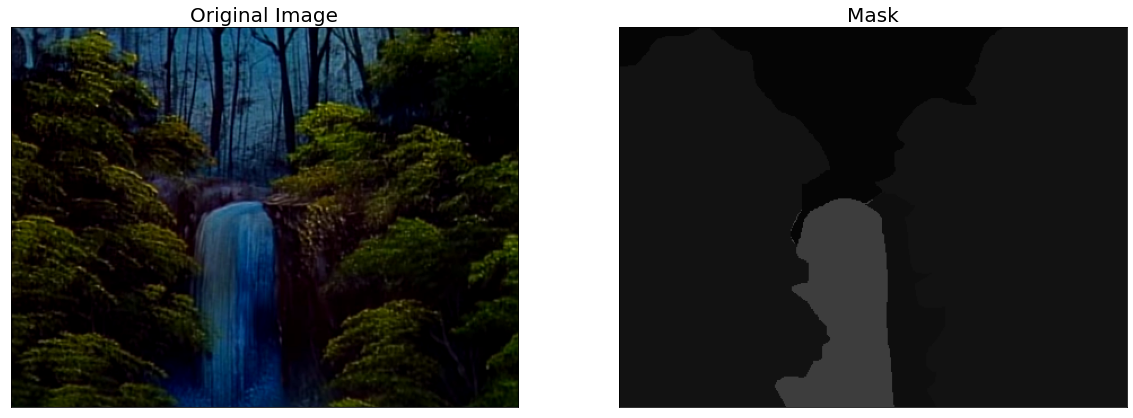

In [ ]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()


image = cv2.cvtColor(cv2.imread(paths_df['image_path'][0]), cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(cv2.imread(paths_df['mask_path'][0]), cv2.COLOR_BGR2RGB)

visualize(
    original_image = image,
    mask = mask
)

In [ ]:
cv2.cvtColor(cv2.imread(paths_df['mask_path'][0]), cv2.COLOR_BGR2RGB)

array([[[ 5,  5,  5],
        [ 5,  5,  5],
        [ 5,  5,  5],
        ...,
        [18, 18, 18],
        [18, 18, 18],
        [18, 18, 18]],

       [[ 5,  5,  5],
        [ 5,  5,  5],
        [ 5,  5,  5],
        ...,
        [18, 18, 18],
        [18, 18, 18],
        [18, 18, 18]],

       [[ 5,  5,  5],
        [ 5,  5,  5],
        [ 5,  5,  5],
        ...,
        [18, 18, 18],
        [18, 18, 18],
        [18, 18, 18]],

       ...,

       [[18, 18, 18],
        [18, 18, 18],
        [18, 18, 18],
        ...,
        [18, 18, 18],
        [18, 18, 18],
        [18, 18, 18]],

       [[18, 18, 18],
        [18, 18, 18],
        [18, 18, 18],
        ...,
        [18, 18, 18],
        [18, 18, 18],
        [18, 18, 18]],

       [[18, 18, 18],
        [18, 18, 18],
        [18, 18, 18],
        ...,
        [18, 18, 18],
        [18, 18, 18],
        [18, 18, 18]]], dtype=uint8)

In [ ]:
labels_df = pd.read_csv("./labels.csv")
# Get class names
class_names = labels_df['class'].tolist()
# Get class IDs
class_ids = labels_df['Id'].tolist()

print('All dataset class names and their corresponding IDs in labels:')
print('Class Names: ', class_names)
print('Class IDs: ', class_ids)

All dataset class names and their corresponding IDs in labels:
Class Names:  ['sky', 'tree', 'grass', 'earth;rock', 'mountain;mount', 'plant;flora;plant;life', 'water', 'sea', 'river']
Class IDs:  [3, 5, 10, 14, 17, 18, 22, 27, 61]


In [ ]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['sky', 'tree', 'grass', 'earth;rock', 'mountain;mount', 'plant;flora;plant;life', 'water', 'sea', 'river']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_ids =  np.array(class_ids)[select_class_indices]
select_colors = [( 112, 150, 146), ( 190, 250, 190), (51, 51, 0), (119, 11, 32), (9, 143, 150), (102, 51, 0), (255, 22, 96), (190, 153, 153), (254, 228, 12)]
print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', select_classes)
print('Class IDs: ', select_class_ids)
print('Class IDs: ', select_colors)

print('Class Names: ', len(select_classes))
print('Class IDs: ', len(select_class_ids))
print('Class IDs: ', len(select_colors))


Selected classes and their corresponding RGB values in labels:
Class Names:  ['sky', 'tree', 'grass', 'earth;rock', 'mountain;mount', 'plant;flora;plant;life', 'water', 'sea', 'river']
Class IDs:  [ 3  5 10 14 17 18 22 27 61]
Class IDs:  [(112, 150, 146), (190, 250, 190), (51, 51, 0), (119, 11, 32), (9, 143, 150), (102, 51, 0), (255, 22, 96), (190, 153, 153), (254, 228, 12)]
Class Names:  9
Class IDs:  9
Class IDs:  9


In [ ]:
def load_painting():

    results = []
    image_paths = paths_df['image_path'].tolist()
    mask_paths = paths_df['mask_path'].tolist()

    counter = 0
    for image_file, gt_file in zip(image_paths, mask_paths):

        # PIL Image is efficient as it doesn't read image to retrieve size
        im = Image.open(image_file)
        width, height = im.size

        results.append({
            "file_name": image_file,
            "image_id": counter,
            "sem_seg_file_name": gt_file,
            "height": height,
            "width": width
            }
        )
        counter = counter + 1

    assert len(results),  f"No images found in {image_dir}!"
    assert PathManager.isfile(results[0]["sem_seg_file_name"]
    ), "Passed"  # noqa

    return results



############ Register Dataset########
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_name = "painting"
stuff_colors = [k for k in select_colors]
stuff_classes = [k for k in select_classes]
# print(stuff_classes)



DatasetCatalog.register(dataset_name, load_painting)

MetadataCatalog.get(dataset_name).set(stuff_colors=stuff_colors, 
                                      stuff_classes=stuff_classes,
                                      evaluator_type="cityscapes_sem_seg") # built-in evaluator for semantic seg task

# MetadataCatalog.get(dataset_name).set(stuff_classes=stuff_classes,
#                                       ) # built-in evaluator for semantic seg task



painting_meta = MetadataCatalog.get(dataset_name)

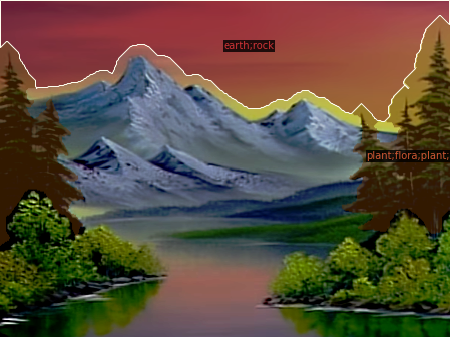

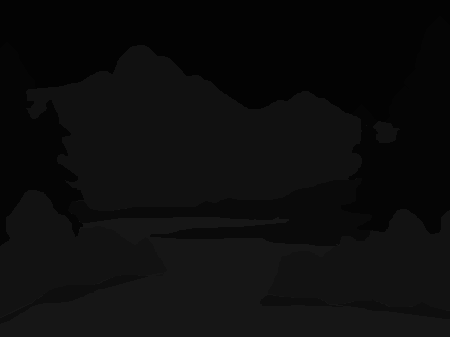

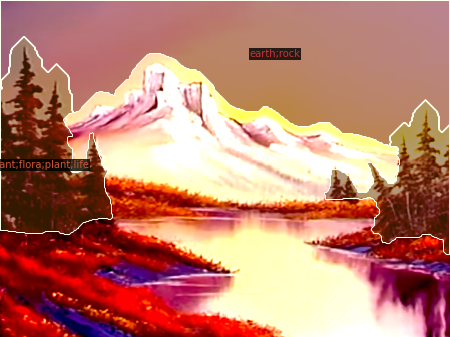

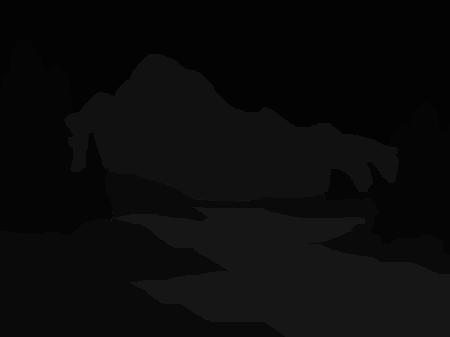

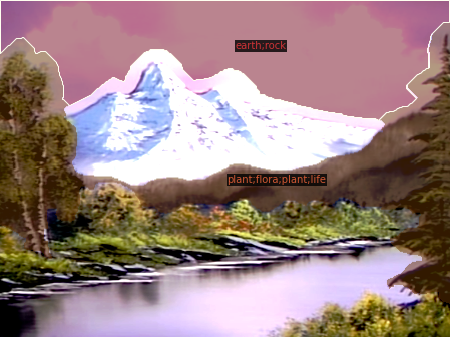

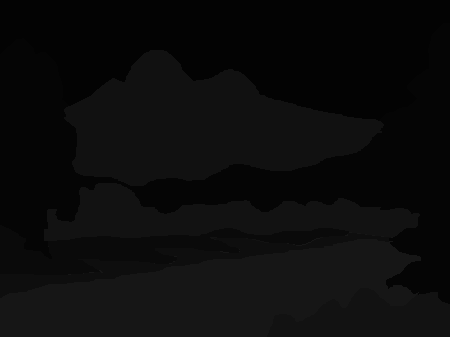

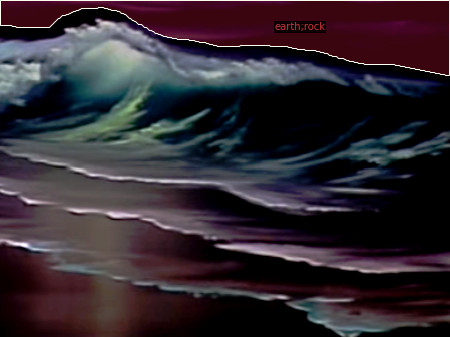

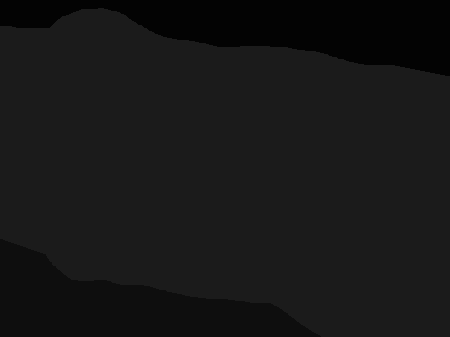

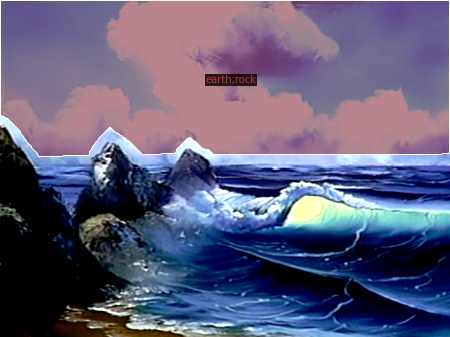

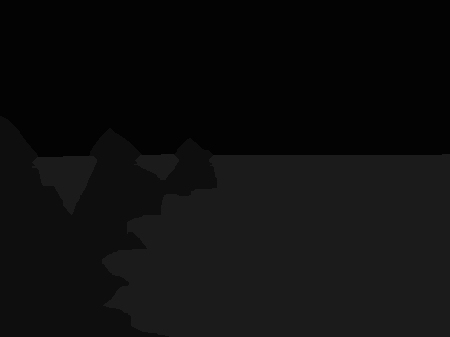

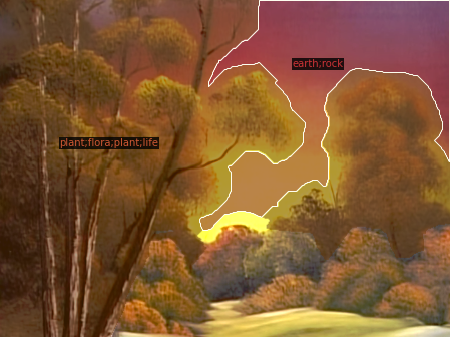

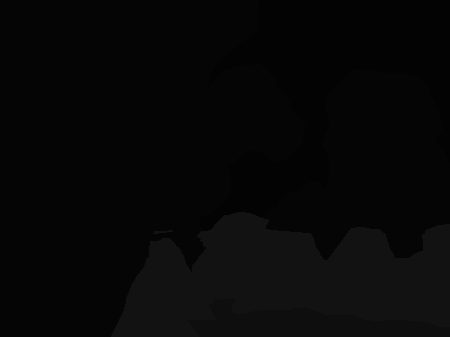

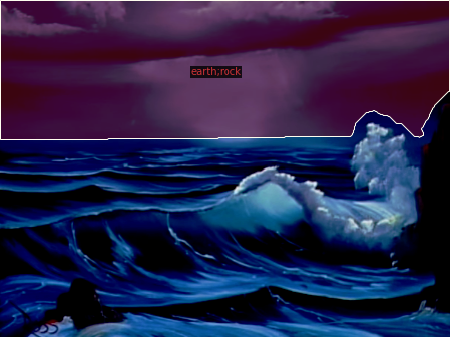

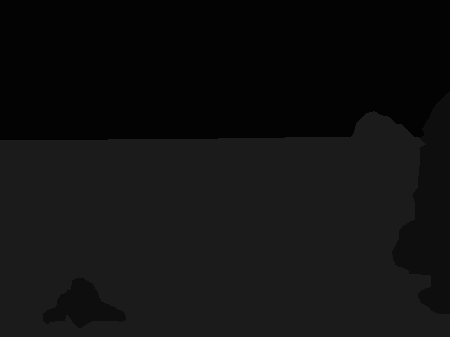

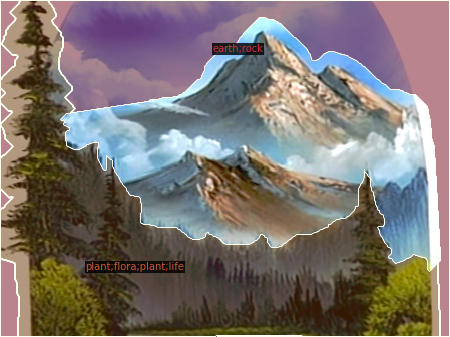

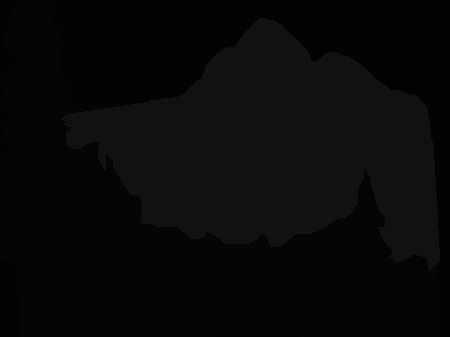

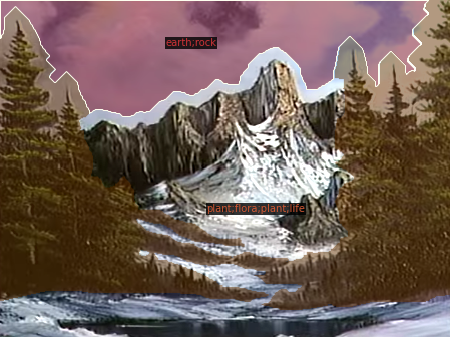

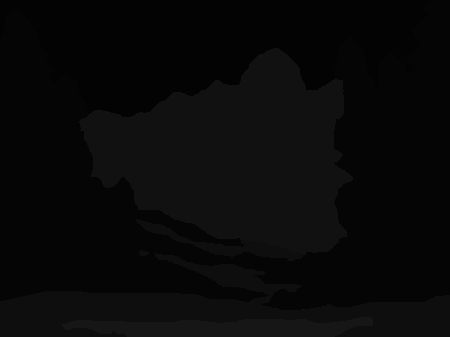

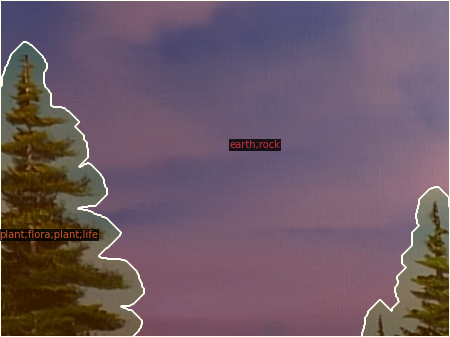

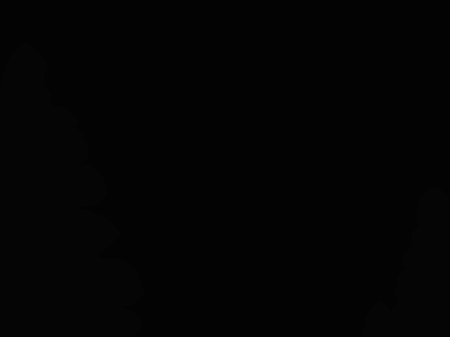

In [ ]:
dataset_dicts = load_painting()
for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    mask = cv2.imread(d["sem_seg_file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=painting_meta, scale=1)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])
    cv2_imshow(mask)
    

In [ ]:
from detectron2.engine import DefaultTrainer, DefaultPredictor, launch
from detectron2.config import get_cfg




In [ ]:
base_conf = "COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(base_conf))
cfg.DATASETS.TRAIN = ("painting",)
cfg.DATASETS.TEST = ()
cfg.TEST.EVAL_PERIOD = 100
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(base_conf)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1  
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = len(select_class_ids)

# Visualization

The labels.csv file has non contiguous values for the labels. 
![picture](https://drive.google.com/uc?export=view&id=1NS1DhrQykH0ta2p6DhEe4tMKWNfV1tZr)

Let's convert these into contiguous values for ease of visualization and evaluation

In [ ]:
def remap_mask_labels_to_contiguous_ints():
  
  # Your code goes here
  # Create new mask files after remap and place them in REM_MASK_DIR

SyntaxError: ignored

In [ ]:
def train_val_split(IMAGE_DIR, ):

    # Your code goes here

    return (train_files, val_files)

In [ ]:
def get_painting_dicts(filenames):
    
    # Your code goes here

    return dataset_dicts

In [ ]:
def reset():
    DatasetCatalog.clear()
    MetadataCatalog.clear()

---
Keep all functions above this line
---

In [ ]:
reset()

remap_mask_labels_to_contiguous_ints()

In [ ]:
train_files, val_files = train_val_split(IMAGE_DIR)

for d, files in [("train", train_files), ("val", val_files)]:
    # Register Catalogs


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:

In [ ]:
# Visualize 3 random samples from the dataset

## Train!


In [ ]:
cfg = get_cfg()

# Your code goes here
# Configure the trainer and start training

In [ ]:
# # Look at training curves in tensorboard:
# %load_ext tensorboard
# %tensorboard --logdir output

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the painting validation dataset. First, let's create a predictor using the model we just trained:

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We should change it a little bit for inference:

# cfg.

In [ ]:
# Visualize inference of 3 random samples 

In [ ]:
# Evaluate metrics and print

# pp = pprint.PrettyPrinter()

#evaluator = 
#val_loader = 
#pp.pprint(inference_on_dataset(predictor.model, val_loader, evaluator))